Train size: 3052
Val size:   656
Test size:  657
=== Validation Results (SVM) ===
              precision    recall  f1-score   support

          -1      0.785     0.915     0.845       448
           0      0.327     0.375     0.350        48
           1      0.696     0.344     0.460       160

    accuracy                          0.736       656
   macro avg      0.603     0.545     0.552       656
weighted avg      0.730     0.736     0.715       656

=== Test Results (SVM) ===
              precision    recall  f1-score   support

          -1      0.739     0.923     0.821       417
           0      0.408     0.377     0.392        53
           1      0.724     0.337     0.460       187

    accuracy                          0.712       657
   macro avg      0.624     0.546     0.558       657
weighted avg      0.708     0.712     0.684       657

Confusion Matrix (SVM) on Test:
[[385  17  15]
 [ 24  20   9]
 [112  12  63]]


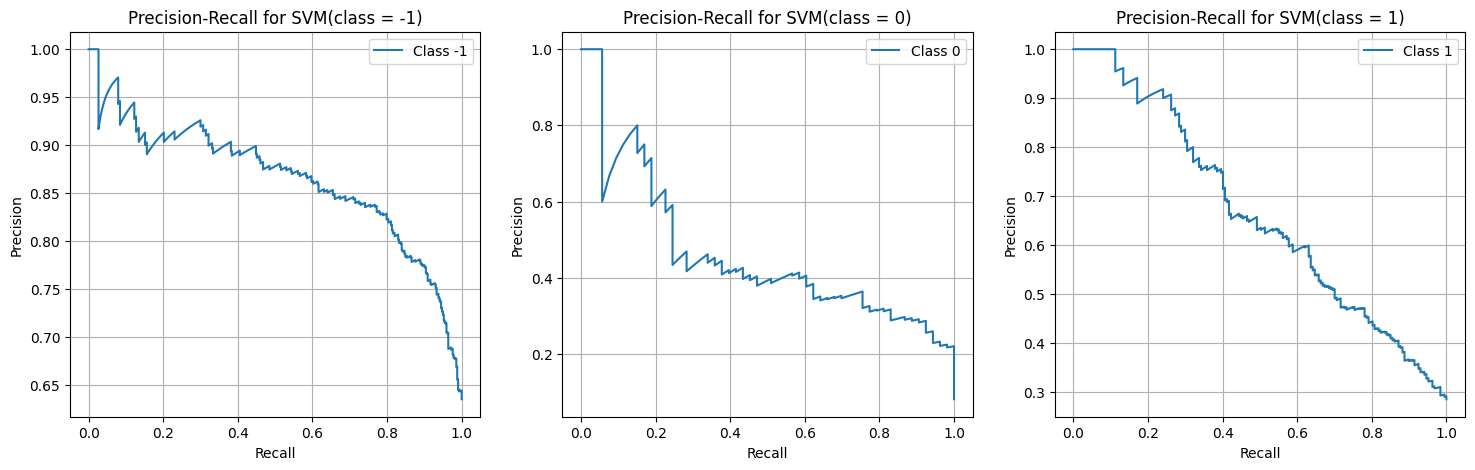

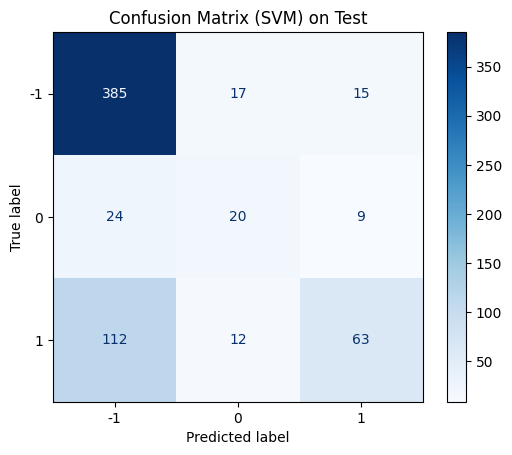

<Figure size 640x480 with 0 Axes>

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np


# 1. LOAD AND MERGE DATA
DATA_DIR = "data"

mtcsd_train = pd.read_csv(os.path.join(DATA_DIR, "MT-CSD_train.csv"))
mtcsd_dev   = pd.read_csv(os.path.join(DATA_DIR, "MT-CSD_dev.csv"))
mtcsd_test  = pd.read_csv(os.path.join(DATA_DIR, "MT-CSD_test.csv"))

vast_train = pd.read_csv(os.path.join(DATA_DIR, "VAST_train.csv"))
vast_dev   = pd.read_csv(os.path.join(DATA_DIR, "VAST_dev.csv"))
vast_test  = pd.read_csv(os.path.join(DATA_DIR, "VAST_test.csv"))

ruw_train = pd.read_csv(os.path.join(DATA_DIR, "Russia-Ukraine_War_train.csv"))
ruw_dev   = pd.read_csv(os.path.join(DATA_DIR, "Russia-Ukraine_War_dev.csv"))
ruw_test  = pd.read_csv(os.path.join(DATA_DIR, "Russia-Ukraine_War_test.csv"))

vt_train = pd.read_csv(os.path.join(DATA_DIR, "Various_Tweets_(2023)_train.csv"))
vt_val   = pd.read_csv(os.path.join(DATA_DIR, "Various_Tweets_(2023)_dev.csv"))
vt_test  = pd.read_csv(os.path.join(DATA_DIR, "Various_Tweets_(2023)_test.csv"))

train_df = pd.concat([mtcsd_train, vast_train, ruw_train, vt_train], ignore_index=True)
val_df   = pd.concat([mtcsd_dev,   vast_dev,   ruw_dev, vt_val],   ignore_index=True)
test_df  = pd.concat([mtcsd_test,  vast_test,  ruw_test,  vt_test],  ignore_index=True)

print("Train size:", len(train_df))
print("Val size:  ", len(val_df))
print("Test size: ", len(test_df))

# 2. COMBINE TEXT COLUMNS
def combine_text(row):
    return f"Target: {row['Target']} [SEP] Context: {row['Context']} [SEP] Text: {row['Text']}"

"""
#for no context
def combine_text(row):
    return f"Target: {row['Target']} [SEP] Text: {row['Text']}"
"""
train_df["combined_text"] = train_df.apply(combine_text, axis=1)
val_df["combined_text"]   = val_df.apply(combine_text, axis=1)
test_df["combined_text"]  = test_df.apply(combine_text, axis=1)

# 3. EXTRACT FEATURES USING TF-IDF
vectorizer = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1,2),      # unigrams + bigrams
    stop_words=None,        # or specify a Turkish stopword list if needed
    lowercase=True
)

X_train = vectorizer.fit_transform(train_df["combined_text"])
X_val   = vectorizer.transform(val_df["combined_text"])
X_test  = vectorizer.transform(test_df["combined_text"])

y_train = train_df["Stance"].values  # labels are -1, 0, 1
y_val   = val_df["Stance"].values
y_test  = test_df["Stance"].values

# 4. TRAIN AN SVM CLASSIFIER
clf = SVC(kernel="linear", probability=True, random_state=42)
clf.fit(X_train, y_train)

# 5. EVALUATE ON VALIDATION
y_val_pred = clf.predict(X_val)

print("=== Validation Results (SVM) ===")
print(classification_report(y_val, y_val_pred, digits=3))

# 6. EVALUATE ON TEST
y_test_pred = clf.predict(X_test)

print("=== Test Results (SVM) ===")
print(classification_report(y_test, y_test_pred, digits=3))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("Confusion Matrix (SVM) on Test:")
print(cm)

# 7. PRECISION-RECALL CURVES (one-vs-rest)
# For multi-class P/R curves, we binarize each label vs. the rest.
unique_labels = sorted(list(set(y_train)) )  # should be [-1, 0, 1], but sorted => [-1, 0, 1]

y_test_binarized = label_binarize(y_test, classes=unique_labels)
# For SVM, we can get decision_function or predict_proba. We used probability=True, so .predict_proba is possible:
y_score = clf.predict_proba(X_test)

# Plot
plt.figure(figsize=(18, 5))
for i, label_val in enumerate(unique_labels):
    y_true = y_test_binarized[:, i]
    y_scores = y_score[:, i]

    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    plt.subplot(1, len(unique_labels), i+1)
    plt.plot(recall, precision, label=f"Class {label_val}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall for SVM(class = {label_val})")
    plt.grid(True)
    plt.legend()

# Define the confusion matrix values (replace with your own)
confusion_matrix_values = cm

# Define the class labels
class_labels = [-1, 0, 1]

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_values, display_labels=class_labels)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (SVM) on Test")
plt.show()


plt.tight_layout()
plt.show()
